# 生成图标

## 导入图标

In [2]:
import plyvel
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
import re
from io import BytesIO
import shutil
from PIL import Image
import os
import json
import unicodedata

In [10]:
# Adjust to your local path:
path = '/home/lq/datasets/icons'
db = plyvel.DB(path)

In [11]:
splitter = re.compile(b'[\x00-\x08]')

def parse_value(value):
    res = {}
    prev = ''
    for elem in splitter.split(value):
        if not elem:
            continue
        try:
            elem = elem.decode('utf8')
        except UnicodeDecodeError:
            continue
        if elem in ('category', 'name', 'platform', 'canonical_name', 'svg'):
            if elem == 'name' and len(prev) == 1:
                prev = 'u_' + unicodedata.name(prev).lower().replace(' ', '_')
            res[elem] = prev
        prev = elem
    return res

for _, value in db:
    res = parse_value(value)
    break
res

{'canonical_name': 'Address Book',
 'category': 'Messaging',
 'name': 'address_book',
 'platform': 'windows',
 'svg': '<?xml version="1.0" encoding="utf-8"?>\n<!-- Generator: Adobe Illustrator 15.0.0, SVG Export Plug-In . SVG Version: 6.00 Build 0)  -->\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" id="Layer_1" x="0px" y="0px" width="26px" height="26px" viewBox="0 0 26 26" enable-background="new 0 0 26 26" xml:space="preserve">\n\n<path fill="#000000" d="M12.792,9.803c-0.221,0-0.423,0.053-0.618,0.166c-0.2,0.111-0.399,0.302-0.594,0.562  c-0.198,0.266-0.359,0.593-0.48,0.977c-0.121,0.385-0.184,0.741-0.184,1.061c0,0.488,0.115,0.867,0.34,1.126  c0.371,0.428,0.811,0.485,1.343,0.205c0.225-0.121,0.444-0.304,0.653-0.543c0.207-0.241,0.382-0.553,0.517-0.929  c0.136-0.378,0.206-0.759,0.206-1.137c0-0.481-0.119-0.855-0.354-1.112C13.393,9.926,13.12,9.

In [12]:
icons = {}

for key, value in db:
    try:
        res = parse_value(value)
    except ValueError:
        continue
    if res.get('platform') == 'ios':
        name = res.get('name')
        if not name:
            name = res.get('canonical_name')
            if not name:
                continue
            name = name.lower().replace(' ', '_')
        icons[name] = res
len(icons)

12420

In [20]:
SIZES = (16, 28, 32, 50)

if os.path.isdir('icons'):
    shutil.rmtree('icons')
os.mkdir('icons')
for size in SIZES:
    os.mkdir('icons/png%s' % size)
os.mkdir('icons/svg')

In [21]:
saved = []
for icon in icons.values():
    icon = dict(icon)
    if not 'svg' in icon:
        continue
    svg = icon.pop('svg')
    try:
        drawing = svg2rlg(BytesIO(svg.encode('utf8')))
    except ValueError:
        continue
    except AttributeError:
        continue
    except TypeError:
        continue
    open('icons/svg/%s.svg' % icon['name'], 'w').write(svg)
    p = renderPM.drawToPIL(drawing)
    for size in SIZES:
        resized = p.resize((size, size), Image.ANTIALIAS)
        resized.save('icons/png%s/%s.png' % (size, icon['name']))
    saved.append(icon)
json.dump(saved, open('icons/index.json', 'w'), indent=2)
len(saved)

Can't handle color: url(#SVGID_1_)


12375

In [22]:
icon['name']

'scorpio_filled'

## 图标自编码

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Concatenate, Flatten, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import json
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

Using TensorFlow backend.


In [2]:
def load_icons(train_size=0.85):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

/home/lq/anaconda2/envs/cookbook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((5177, 32, 32, 1), (914, 32, 32, 1))

In [3]:
x_train.shape

(5177, 32, 32, 1)

In [4]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)

    for i in range(5):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 4)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 8)    0           conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
__________

In [5]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 5177 samples, validate on 914 samples
Epoch 1/100
5177/5177 [==============================] - 2s 397us/step - loss: 0.6052 - val_loss: 0.5229
Epoch 2/100
5177/5177 [==============================] - 1s 245us/step - loss: 0.5208 - val_loss: 0.4885
Epoch 3/100
5177/5177 [==============================] - 1s 244us/step - loss: 0.5019 - val_loss: 0.4987
Epoch 4/100
5177/5177 [==============================] - 1s 244us/step - loss: 0.4936 - val_loss: 0.4891
Epoch 5/100
5177/5177 [==============================] - 1s 246us/step - loss: 0.4918 - val_loss: 0.4932
Epoch 6/100
5177/5177 [==============================] - 1s 245us/step - loss: 0.4886 - val_loss: 0.4851
Epoch 7/100
5177/5177 [==============================] - 1s 246us/step - loss: 0.4892 - val_loss: 0.4809
Epoch 8/100
5177/5177 [==============================] - 1s 245us/step - loss: 0.4877 - val_loss: 0.4860
Epoch 9/100
5177/5177 [==============================] - 1s 244us/step - loss: 0.4882 - val_loss: 0.4811
Epoch 10

Epoch 78/100
5177/5177 [==============================] - 1s 243us/step - loss: 0.3815 - val_loss: 0.3823
Epoch 79/100
5177/5177 [==============================] - 1s 243us/step - loss: 0.3812 - val_loss: 0.3815
Epoch 80/100
5177/5177 [==============================] - 1s 242us/step - loss: 0.3811 - val_loss: 0.3800
Epoch 81/100
5177/5177 [==============================] - 1s 243us/step - loss: 0.3806 - val_loss: 0.3801
Epoch 82/100
5177/5177 [==============================] - 1s 243us/step - loss: 0.3798 - val_loss: 0.3771
Epoch 83/100
5177/5177 [==============================] - 1s 242us/step - loss: 0.3789 - val_loss: 0.3798
Epoch 84/100
5177/5177 [==============================] - 1s 243us/step - loss: 0.3788 - val_loss: 0.3803
Epoch 85/100
5177/5177 [==============================] - 1s 242us/step - loss: 0.3776 - val_loss: 0.3768
Epoch 86/100
5177/5177 [==============================] - 1s 244us/step - loss: 0.3778 - val_loss: 0.3773
Epoch 87/100
5177/5177 [======================

In [6]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

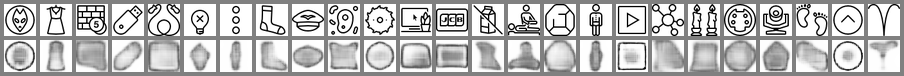

In [7]:
def decode_img(tile):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 36 + 4, 64 + 12), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 36 + 4, 4))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 36 + 4, 40))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))

In [8]:
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)

x_train_aug = augment(x_train)
x_test_aug = augment(x_test)
x_train_aug.shape

(82832, 32, 32, 1)

In [9]:
from keras.callbacks import TensorBoard
autoencoder = create_autoencoder()
autoencoder.fit(x_train_aug, x_train_aug,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_aug, x_test_aug),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 82832 samples, validate on 14624 samples
Epoch 1/100
82832/82832 [==============================] - 20s 246us/step - loss: 0.4983 - val_loss: 0.4800
Epoch 2/100
82832/82832 [==============================] - 20s 244us/step - loss: 0.4596 - val_loss: 0.4328
Epoch 3/100
82832/82832 [==============================] - 20s 245us/step - loss: 0.4266 - val_loss: 0.4147
Epoch 4/100
82832/82832 [==============================] - 20s 242us/step - loss: 0.4060 - val_loss: 0.3960
Epoch 5/100
82832/82832 [==============================] - 20s 240us/step - loss: 0.3921 - val_loss: 0.3953
Epoch 6/100
82832/82832 [==============================] - 20s 239us/step - loss: 0.3843 - val_loss: 0.3829
Epoch 7/100
82832/82832 [==============================] - 20s 239us/step - loss: 0.3790 - val_loss: 0.3760
Epoch 8/100
82832/82832 [==============================] - 20s 239us/step - loss: 0.3745 - val_loss: 0.3715
Epoch 9/100
82832/82832 [==============================] - 20s 239us/step - loss: 0.37

Epoch 76/100
82832/82832 [==============================] - 20s 240us/step - loss: 0.3041 - val_loss: 0.3088
Epoch 77/100
82832/82832 [==============================] - 20s 240us/step - loss: 0.3038 - val_loss: 0.3097
Epoch 78/100
82832/82832 [==============================] - 20s 240us/step - loss: 0.3035 - val_loss: 0.3079
Epoch 79/100
82832/82832 [==============================] - 20s 241us/step - loss: 0.3032 - val_loss: 0.3062
Epoch 80/100
82832/82832 [==============================] - 20s 239us/step - loss: 0.3029 - val_loss: 0.3090
Epoch 81/100
82832/82832 [==============================] - 20s 240us/step - loss: 0.3027 - val_loss: 0.3028
Epoch 82/100
82832/82832 [==============================] - 20s 240us/step - loss: 0.3022 - val_loss: 0.3060
Epoch 83/100
82832/82832 [==============================] - 20s 241us/step - loss: 0.3020 - val_loss: 0.3089
Epoch 84/100
82832/82832 [==============================] - 20s 241us/step - loss: 0.3018 - val_loss: 0.3041
Epoch 85/100
82832/

In [10]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

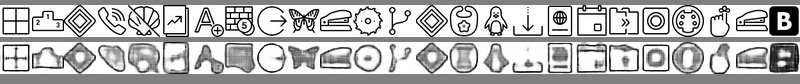

In [11]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))

In [12]:
batch_size = 250
latent_space_depth = 128

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps

In [13]:
def VariationalAutoEncoder(num_pixels):
    
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.0001 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return binary_crossentropy(y_true, y_pred)

    def total_loss(y_true, y_pred):
        return reconstruction_loss(y_true, y_pred) + KL_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_in = Input(shape=(latent_space_depth,))

    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    e_x = Reshape((1, 1, latent_space_depth))(z)
    for i in range(5):
        conv = Conv2D(channels, (3, 3), activation='relu', padding='same')
        upsampling = UpSampling2D((2, 2))
        d_x = conv(d_x)
        d_x = upsampling(d_x)
        e_x = conv(e_x)
        e_x = upsampling(e_x)
        channels //= 2

    final_conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    auto_decoded = final_conv(e_x)
    decoder_out = final_conv(d_x)
    
    decoder = Model(decoder_in, decoder_out)    
    
    auto_encoder = Model(input_img, auto_decoded)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

var_auto_encoder, decoder = VariationalAutoEncoder(32)
var_auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 32, 4)    40          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 32, 32, 4)    20          input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 32, 32, 8)    0           conv2d_33[0][0]                  
                                                                 conv2d_34[0][0]                  
__________

In [14]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 1, 128)         147584    
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 2, 2, 64)          73792     
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 4, 4, 32)          18464     
__________

In [15]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train)
x_test_trunc = truncate_to_batch(x_test)
x_train_trunc.shape, x_test_trunc.shape

((5000, 32, 32, 1), (750, 32, 32, 1))

In [16]:
var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

Train on 5000 samples, validate on 750 samples
Epoch 1/100
5000/5000 [==============================] - 2s 363us/step - loss: 0.5598 - KL_loss: 3.2806e-04 - reconstruction_loss: 0.5595 - val_loss: 0.5168 - val_KL_loss: 7.2611e-05 - val_reconstruction_loss: 0.5167
Epoch 2/100
5000/5000 [==============================] - 1s 224us/step - loss: 0.5096 - KL_loss: 5.8838e-05 - reconstruction_loss: 0.5095 - val_loss: 0.4962 - val_KL_loss: 7.0811e-05 - val_reconstruction_loss: 0.4961
Epoch 3/100
5000/5000 [==============================] - 1s 224us/step - loss: 0.4935 - KL_loss: 2.5083e-04 - reconstruction_loss: 0.4933 - val_loss: 0.4850 - val_KL_loss: 0.0011 - val_reconstruction_loss: 0.4839
Epoch 4/100
5000/5000 [==============================] - 1s 224us/step - loss: 0.4849 - KL_loss: 8.6628e-04 - reconstruction_loss: 0.4841 - val_loss: 0.4800 - val_KL_loss: 0.0010 - val_reconstruction_loss: 0.4790
Epoch 5/100
5000/5000 [==============================] - 1s 227us/step - loss: 0.4813 - KL_lo

Epoch 40/100
5000/5000 [==============================] - 1s 220us/step - loss: 0.3972 - KL_loss: 0.0070 - reconstruction_loss: 0.3903 - val_loss: 0.3982 - val_KL_loss: 0.0072 - val_reconstruction_loss: 0.3910
Epoch 41/100
5000/5000 [==============================] - 1s 223us/step - loss: 0.3961 - KL_loss: 0.0071 - reconstruction_loss: 0.3890 - val_loss: 0.3955 - val_KL_loss: 0.0071 - val_reconstruction_loss: 0.3884
Epoch 42/100
5000/5000 [==============================] - 1s 220us/step - loss: 0.3957 - KL_loss: 0.0071 - reconstruction_loss: 0.3885 - val_loss: 0.3971 - val_KL_loss: 0.0072 - val_reconstruction_loss: 0.3899
Epoch 43/100
5000/5000 [==============================] - 1s 220us/step - loss: 0.3954 - KL_loss: 0.0070 - reconstruction_loss: 0.3884 - val_loss: 0.3957 - val_KL_loss: 0.0073 - val_reconstruction_loss: 0.3884
Epoch 44/100
5000/5000 [==============================] - 1s 220us/step - loss: 0.3937 - KL_loss: 0.0071 - reconstruction_loss: 0.3866 - val_loss: 0.3936 - val_

5000/5000 [==============================] - 1s 222us/step - loss: 0.3713 - KL_loss: 0.0073 - reconstruction_loss: 0.3640 - val_loss: 0.3770 - val_KL_loss: 0.0072 - val_reconstruction_loss: 0.3698
Epoch 80/100
5000/5000 [==============================] - 1s 221us/step - loss: 0.3710 - KL_loss: 0.0072 - reconstruction_loss: 0.3637 - val_loss: 0.3771 - val_KL_loss: 0.0071 - val_reconstruction_loss: 0.3700
Epoch 81/100
5000/5000 [==============================] - 1s 222us/step - loss: 0.3716 - KL_loss: 0.0071 - reconstruction_loss: 0.3644 - val_loss: 0.3761 - val_KL_loss: 0.0072 - val_reconstruction_loss: 0.3688
Epoch 82/100
5000/5000 [==============================] - 1s 220us/step - loss: 0.3700 - KL_loss: 0.0072 - reconstruction_loss: 0.3628 - val_loss: 0.3748 - val_KL_loss: 0.0071 - val_reconstruction_loss: 0.3677
Epoch 83/100
5000/5000 [==============================] - 1s 221us/step - loss: 0.3694 - KL_loss: 0.0072 - reconstruction_loss: 0.3622 - val_loss: 0.3752 - val_KL_loss: 0.00

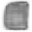

In [17]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))

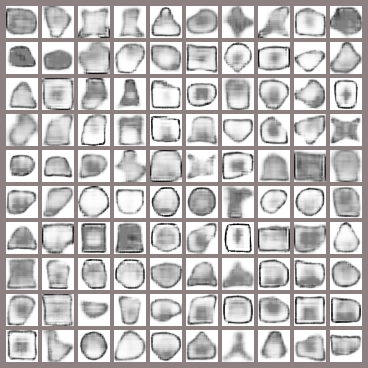

In [18]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.4 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [19]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train_aug)
x_test_trunc = truncate_to_batch(x_test_aug)
x_train_trunc.shape, x_test_trunc.shape

var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

Train on 82750 samples, validate on 14500 samples
Epoch 1/100
82750/82750 [==============================] - 19s 224us/step - loss: 0.3781 - KL_loss: 0.0069 - reconstruction_loss: 0.3713 - val_loss: 0.3716 - val_KL_loss: 0.0071 - val_reconstruction_loss: 0.3645
Epoch 2/100
82750/82750 [==============================] - 18s 223us/step - loss: 0.3721 - KL_loss: 0.0072 - reconstruction_loss: 0.3649 - val_loss: 0.3675 - val_KL_loss: 0.0074 - val_reconstruction_loss: 0.3601
Epoch 3/100
82750/82750 [==============================] - 19s 224us/step - loss: 0.3683 - KL_loss: 0.0073 - reconstruction_loss: 0.3610 - val_loss: 0.3639 - val_KL_loss: 0.0074 - val_reconstruction_loss: 0.3566
Epoch 4/100
82750/82750 [==============================] - 18s 223us/step - loss: 0.3653 - KL_loss: 0.0076 - reconstruction_loss: 0.3577 - val_loss: 0.3613 - val_KL_loss: 0.0076 - val_reconstruction_loss: 0.3537
Epoch 5/100
82750/82750 [==============================] - 19s 224us/step - loss: 0.3629 - KL_loss: 0.

82750/82750 [==============================] - 18s 222us/step - loss: 0.3275 - KL_loss: 0.0102 - reconstruction_loss: 0.3172 - val_loss: 0.3281 - val_KL_loss: 0.0102 - val_reconstruction_loss: 0.3179
Epoch 78/100
82750/82750 [==============================] - 18s 222us/step - loss: 0.3274 - KL_loss: 0.0102 - reconstruction_loss: 0.3171 - val_loss: 0.3288 - val_KL_loss: 0.0101 - val_reconstruction_loss: 0.3187
Epoch 79/100
82750/82750 [==============================] - 18s 222us/step - loss: 0.3273 - KL_loss: 0.0102 - reconstruction_loss: 0.3170 - val_loss: 0.3284 - val_KL_loss: 0.0102 - val_reconstruction_loss: 0.3182
Epoch 80/100
82750/82750 [==============================] - 18s 222us/step - loss: 0.3271 - KL_loss: 0.0102 - reconstruction_loss: 0.3169 - val_loss: 0.3275 - val_KL_loss: 0.0102 - val_reconstruction_loss: 0.3173
Epoch 81/100
82750/82750 [==============================] - 18s 222us/step - loss: 0.3270 - KL_loss: 0.0103 - reconstruction_loss: 0.3167 - val_loss: 0.3285 - va

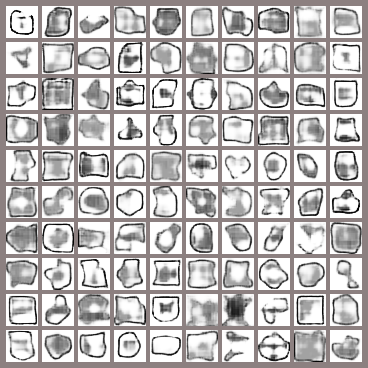

In [20]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.2 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

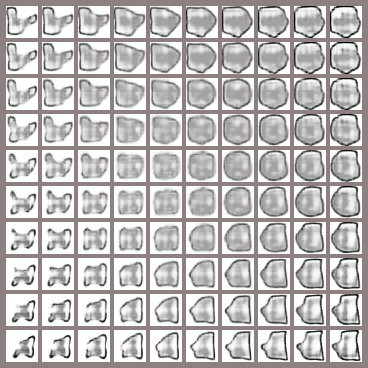

In [21]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[ - (i % 2) * (x - 4.5) / 3 + ((i + 1) % 2) * (y - 4.5) / 3
                            for i in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

## 变化自动编码

In [22]:
import numpy as np
from keras.layers import Input, Dense, Lambda, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import json
from collections import Counter
from io import BytesIO
import PIL
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import clear_output, Image, display, HTML

In [23]:
batch_size = 250 # batch size

def augment(icons, labels, size):
    aug_icons = []
    aug_labels = []
    for icon, label in zip(icons, labels):
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                aug_labels.append(label)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
            if flip % 2 == 0:
                icon = np.flipud(icon)
    aug_icons = np.asarray(aug_icons) / 255

    return aug_icons, np.asarray(aug_labels)

def load_icons(train_size=0.90, size=28):
    icon_index = json.load(open('icons/index.json'))
    cat_count = Counter(icon['category'] for icon in icon_index)
    cats = [cat for cat, count in cat_count.items() if count > 50]
    cat_to_index = {cat: idx for idx, cat in enumerate(cats)}
    x = []
    y = []
    img_rows, img_cols = size, size
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        cat_idx = cat_to_index.get(icon['category'])
        if cat_idx is None:
            continue
        img_path = 'icons/png%d/%s.png' % (size, icon['name'])
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
        y.append(cat_idx)
    target_size = len(x) - (len(x) % batch_size)
    x = x[:target_size]
    y = y[:target_size]
    x = np.asarray(x)
    y = np.asarray(y)
    train_size = int(train_size * x.shape[0])
    train_size -= train_size % batch_size
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
    x_train, y_train = augment(x_train, y_train, size=size)
    x_test, y_test = augment(x_test, y_test, size=size)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_icons(size=32)
x_train.shape

/home/lq/anaconda2/envs/cookbook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(80000, 32, 32, 1)

In [24]:
batch_size = 250
latent_space_depth = 128

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps

In [25]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels, num_pixels, 1))
    channels = 4
    x = pixels
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x) 
    x = Flatten()(x)
    encoder_hidden = Dense(latent_space_depth, name='encoder_hidden')(x)

    z_mean = Dense(latent_space_depth, activation='linear', name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear', name='z_log_var')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    up_samp0 = UpSampling2D((2, 2))
    up_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
    up_samp1 = UpSampling2D((2, 2))
    up_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')
    up_samp2 = UpSampling2D((2, 2))
    up_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')
    up_samp3 = UpSampling2D((2, 2))
    up_conv4 = Conv2D(4, (3, 3), activation='relu', padding='same')
    up_samp4 = UpSampling2D((2, 2))
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    decoder_in = Input(shape=(latent_space_depth,))
    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    d_x = up_samp0(d_x)
    d_x = up_conv1(d_x)
    d_x = up_samp1(d_x)
    d_x = up_conv2(d_x)
    d_x = up_samp2(d_x)
    d_x = up_conv3(d_x)
    d_x = up_samp3(d_x)
    d_x = up_conv4(d_x)
    d_x = up_samp4(d_x)
    decoder_out= decoded(d_x)

    decoder = Model(decoder_in, decoder_out)    

    a_x = Reshape((1, 1, latent_space_depth))(z)
    a_x = up_samp0(a_x)
    a_x = up_conv1(a_x)
    a_x = up_samp1(a_x)
    a_x = up_conv2(a_x)
    a_x = up_samp2(a_x)
    a_x = up_conv3(a_x)
    a_x = up_samp3(a_x)
    a_x = up_conv4(a_x)
    a_x = up_samp4(a_x)
    outputs= decoded(a_x)
    
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 32, 4)    40          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 32, 32, 4)    20          input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 32, 32, 8)    0           conv2d_49[0][0]                  
                                                                 conv2d_50[0][0]                  
__________

In [26]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((80000, 32, 32, 1), (80000,), (12000, 32, 32, 1), (12000,))

In [27]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 80000 samples, validate on 12000 samples
Epoch 1/100
80000/80000 [==============================] - 17s 215us/step - loss: 502.3411 - KL_loss: 6.8177 - reconstruction_loss: 495.5234 - val_loss: 468.0205 - val_KL_loss: 11.4517 - val_reconstruction_loss: 456.5688
Epoch 2/100
80000/80000 [==============================] - 17s 208us/step - loss: 451.8499 - KL_loss: 13.9091 - reconstruction_loss: 437.9408 - val_loss: 441.0840 - val_KL_loss: 15.6370 - val_reconstruction_loss: 425.4470
Epoch 3/100
80000/80000 [==============================] - 17s 206us/step - loss: 433.3072 - KL_loss: 16.6151 - reconstruction_loss: 416.6921 - val_loss: 429.5088 - val_KL_loss: 17.2239 - val_reconstruction_loss: 412.2849
Epoch 4/100
80000/80000 [==============================] - 17s 206us/step - loss: 423.7204 - KL_loss: 18.2450 - reconstruction_loss: 405.4754 - val_loss: 421.5892 - val_KL_loss: 18.4280 - val_reconstruction_loss: 403.1613
Epoch 5/100
80000/80000 [==============================] - 17s 

Epoch 74/100
80000/80000 [==============================] - 16s 198us/step - loss: 377.4773 - KL_loss: 33.3683 - reconstruction_loss: 344.1090 - val_loss: 380.9098 - val_KL_loss: 33.3672 - val_reconstruction_loss: 347.5425
Epoch 75/100
80000/80000 [==============================] - 16s 198us/step - loss: 377.2707 - KL_loss: 33.3969 - reconstruction_loss: 343.8738 - val_loss: 380.3310 - val_KL_loss: 33.3278 - val_reconstruction_loss: 347.0032
Epoch 76/100
80000/80000 [==============================] - 16s 199us/step - loss: 377.1651 - KL_loss: 33.4358 - reconstruction_loss: 343.7293 - val_loss: 380.0399 - val_KL_loss: 33.8797 - val_reconstruction_loss: 346.1602
Epoch 77/100
80000/80000 [==============================] - 16s 199us/step - loss: 377.0624 - KL_loss: 33.5496 - reconstruction_loss: 343.5128 - val_loss: 380.2750 - val_KL_loss: 33.3030 - val_reconstruction_loss: 346.9721
Epoch 78/100
80000/80000 [==============================] - 16s 199us/step - loss: 377.0868 - KL_loss: 33.60

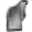

In [28]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])

img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))

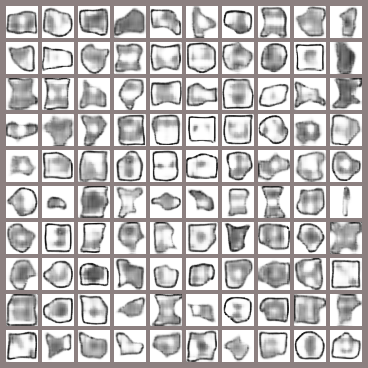

In [29]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

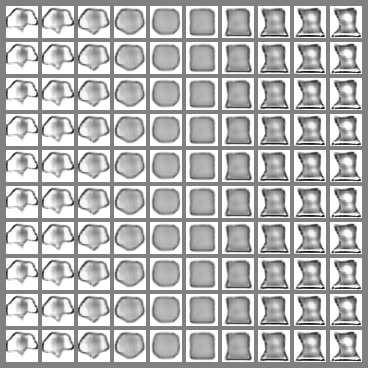

In [30]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[: 1] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
#        vec[: 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

## GAN

In [32]:
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU
from keras.layers import Activation, Conv2D, Lambda, Concatenate, Flatten, Dense, UpSampling2D

from keras.utils import np_utils
import keras
import colorsys
import keras.backend as K
import glob
import json
from sklearn.model_selection import train_test_split
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

import math
import random

import numpy as np
import matplotlib.pyplot as plt

import cv2

In [33]:
BATCH_SIZE = 32
LATENT_SIZE = 128
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)
        

def load_icons(train_size=0.85):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
    return augment(x_train), augment(x_val)

x_train, x_test = load_icons()
x_train.shape, x_test.shape

/home/lq/anaconda2/envs/cookbook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((82832, 32, 32, 1), (14624, 32, 32, 1))

In [34]:
def create_generative_network(latent_size):
    inp = Input(shape=(latent_size,))
    x = Reshape((1, 1, latent_size))(inp)

    channels = latent_size
    padding = 'valid'
    strides = 1
    for i in range(4):
        x = Conv2DTranspose(channels, kernel_size=4,
                            strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(.2)(x)
        
        channels //= 2
        padding = 'same'
        strides = 2

    x = Conv2DTranspose(1, kernel_size=4, strides=1, padding='same')(x)
    image_out = Activation('tanh')(x)

    model = Model(inputs=inp, outputs=image_out)
    return model

generator = create_generative_network(LATENT_SIZE)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 64)          131136    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
__________

In [35]:
def create_discriminative_network():
    inp = Input(shape=(32, 32, 1))
    x = inp

    channels = 16

    for i in range(4):
        layers = []
        conv = Conv2D(channels, 3, strides=2, padding='same')(x)
        if i:
            conv = BatchNormalization()(conv)
        conv = LeakyReLU(.2)(conv)
        layers.append(conv)
        bv = Lambda(lambda x: K.mean(K.abs(x[:] - K.mean(x, axis=0)), 
                                     axis=-1, 
                                     keepdims=True))(conv)
        layers.append(bv)
        channels *= 2
        x = Concatenate()(layers)

    x = Conv2D(128, 2, padding='valid')(x)
    x = Flatten(name='flatten')(x)
    
    fake = Dense(1, activation='sigmoid', name='generation')(x)

    m = Model(inputs=inp, outputs=fake)
    return m

discriminator = create_discriminative_network()
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 16, 16, 16)   160         input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 16)   0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 16, 16, 1)    0           leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
concatenat

In [36]:
def gan(g, d):
    # initialize a GAN trainer

    # this is the fastest way to train a GAN in Keras
    # two models are updated simutaneously in one pass

    noise = Input(shape=g.input_shape[1:])
    real_data = Input(shape=d.input_shape[1:])

    generated = g(noise)
    gscore = d(generated)
    rscore = d(real_data)

    def log_eps(i):
        return K.log(i+1e-11)

    # single side label smoothing: replace 1.0 with 0.9
    dloss = - K.mean(log_eps(1-gscore) + .1 * log_eps(1-rscore) + .9 * log_eps(rscore))
    gloss = - K.mean(log_eps(gscore))

    Adam = tf.train.AdamOptimizer

    lr, b1 = 1e-4, .2 # otherwise won't converge.
    optimizer = Adam(lr,beta1=b1)

    grad_loss_wd = optimizer.compute_gradients(dloss, d.trainable_weights)
    update_wd = optimizer.apply_gradients(grad_loss_wd)

    grad_loss_wg = optimizer.compute_gradients(gloss, g.trainable_weights)
    update_wg = optimizer.apply_gradients(grad_loss_wg)

    def get_internal_updates(model):
        # get all internal update ops (like moving averages) of a model
        inbound_nodes = model.inbound_nodes
        input_tensors = []
        for ibn in inbound_nodes:
            input_tensors+= ibn.input_tensors
        updates = [model.get_updates_for(i) for i in input_tensors]
        return updates

    other_parameter_updates = [get_internal_updates(m) for m in [d,g]]
    # those updates includes batch norm.

    train_step = [update_wd, update_wg, other_parameter_updates]
    losses = [dloss, gloss]

    learning_phase = K.learning_phase()

    def gan_feed(sess,batch_image,z_input):
        # actual GAN trainer
        nonlocal train_step,losses,noise,real_data,learning_phase

        res = sess.run([train_step,losses],feed_dict={
        noise:z_input,
        real_data:batch_image,
        learning_phase:True,
        # Keras layers needs to know whether
        # this run is training or testring (you know, batch norm and dropout)
        })

        loss_values = res[1]
        return loss_values #[dloss,gloss]

    return gan_feed

print('generating GAN...')
gan_feed = gan(generator, discriminator)

generating GAN...


In [37]:
def generate_images(generator, count):
    noise = np.random.normal(loc=0., 
                             scale=1., 
                             size=(count, LATENT_SIZE))
    for tile in generator.predict([noise]).reshape((count, 32, 32)):
        tile = (tile * 300).clip(0, 255).astype('uint8')
        yield PIL.Image.fromarray(tile)

def poster(generator, w_count, h_count):
    overview = PIL.Image.new('RGB', (w_count * 34 + 2, h_count * 34 + 2), (128, 128, 128))
    for idx, img in enumerate(generate_images(generator, w_count * h_count)):
        x = idx % w_count
        y = idx // w_count
        overview.paste(img, (x * 34 + 2, y * 34 + 2))
    return overview

0 dloss: 0.58 gloss: 3.26


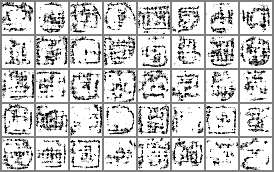

In [38]:
def run(epochs=100):
    sess = K.get_session()
    l = x_train.shape[0]
    l -= l % BATCH_SIZE
    for epoch in range(epochs):
        np.random.shuffle(x_train)
        for batch_start in range(0, l, BATCH_SIZE):
            batch = x_train[batch_start: batch_start + BATCH_SIZE]
            z_input = np.random.normal(loc=0., 
                                       scale=1., 
                                       size=(BATCH_SIZE, LATENT_SIZE))
            dloss, gloss = gan_feed(sess, batch, z_input)
        clear_output(wait=True)
        print('%d dloss: %2.2f gloss: %2.2f' % (epoch, dloss, gloss))
        f = BytesIO()
        poster(generator, 8, 5).save(f, 'png')
        display(Image(data=f.getvalue()))
run(1)

27 dloss: 0.35 gloss: 4.44


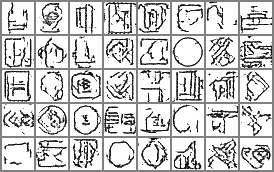

In [ ]:
run(30)

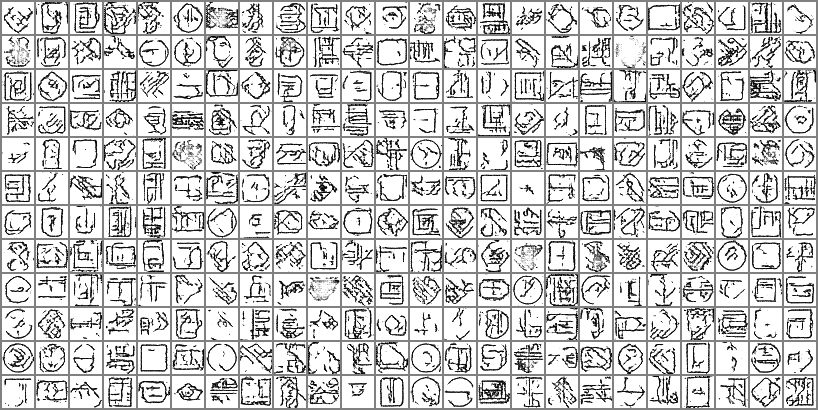

In [41]:
f = BytesIO()
poster(generator, 24, 12).save(f, 'png')
display(Image(data=f.getvalue()))

## RNN

In [42]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, LSTM, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
import random
import matplotlib.pyplot as plt
import json
import keras.callbacks
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [43]:
def encode_icon(img, icon_size):
    size_last_x = 0
    encoded = []
    for y in range(icon_size):
        for x in range(icon_size):
            p = img.getpixel((x, y))
            if img.getpixel((x, y)) < 192:
                encoded.append(x)
                size_last_x = len(encoded)
        encoded.append(icon_size)
    return encoded[:size_last_x]


def decode_icon(encoded, icon_size, rows=None, stop_token=None):
    y = 0
    for idx in encoded:
        if idx == icon_size:
            y += 1
        elif idx == icon_size + 1:
            break
        else:
            x = idx
            yield x, y
            
def make_array(icons):
    res = []
    for icon in icons:
        res.extend(icon)
        res.append(33)
    return np.asarray(res)

def load_icons(train_size=0.90):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = PIL.Image.open(img_path)
        if img.mode != 'L':
            img = img.convert('L')
        x.append(encode_icon(img, 32))
    x_train, x_val = train_test_split(x, train_size=train_size)
    x_train = make_array(x_train)
    x_val = make_array(x_val)
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

/home/lq/anaconda2/envs/cookbook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((1667752,), (180537,))

In [44]:
def icon_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = icon_rnn_model(34, num_layers=2, num_nodes=256, dropout=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 34)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 256)         297984    
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 256)         525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 34)          8738      
Total params: 832,034
Trainable params: 832,034
Non-trainable params: 0
_________________________________________________________________


In [45]:
CHUNK_SIZE = 160

def data_generator(corpus, icon_size, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, icon_size + 2))
    y = np.zeros((batch_size, chunk_size, icon_size + 2))
    while True:
        for row in range(batch_size):
            idx = random.randrange(len(corpus) - chunk_size - 1)
            chunk = np.zeros((chunk_size + 1, icon_size + 2))
            for i in range(chunk_size + 1):
                chunk[i, corpus[idx + i]] = 1
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

next(data_generator(x_train, 32, 1, chunk_size=20))

(array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [46]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
model.fit_generator(
    data_generator(x_train, 32, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    validation_data=data_generator(x_test, 32, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=100,
    callbacks=[early,],
    steps_per_epoch=2 * len(x_train) / (BATCH_SIZE * CHUNK_SIZE),
    validation_steps=2 * len(x_test) / (BATCH_SIZE * CHUNK_SIZE),
    verbose=2
)

Epoch 1/100
 - 38s - loss: 3.6566 - acc: 0.0704 - val_loss: 3.6297 - val_acc: 0.0371
Epoch 2/100
 - 37s - loss: 3.5173 - acc: 0.0871 - val_loss: 3.4930 - val_acc: 0.0507
Epoch 3/100
 - 37s - loss: 3.4828 - acc: 0.0954 - val_loss: 3.4130 - val_acc: 0.1152
Epoch 4/100
 - 37s - loss: 2.8104 - acc: 0.2819 - val_loss: 1.5455 - val_acc: 0.6497
Epoch 5/100
 - 37s - loss: 1.1825 - acc: 0.7113 - val_loss: 1.3095 - val_acc: 0.7037
Epoch 6/100
 - 37s - loss: 0.9071 - acc: 0.7620 - val_loss: 0.8827 - val_acc: 0.7658
Epoch 7/100
 - 37s - loss: 0.8344 - acc: 0.7799 - val_loss: 0.7501 - val_acc: 0.7909
Epoch 8/100
 - 37s - loss: 0.7517 - acc: 0.7965 - val_loss: 0.9395 - val_acc: 0.7723
Epoch 9/100
 - 37s - loss: 0.8054 - acc: 0.7953 - val_loss: 0.9020 - val_acc: 0.7812
Epoch 10/100
 - 37s - loss: 0.6864 - acc: 0.8133 - val_loss: 0.8410 - val_acc: 0.7881
Epoch 11/100
 - 37s - loss: 0.6589 - acc: 0.8201 - val_loss: 0.7687 - val_acc: 0.7981
Epoch 12/100
 - 37s - loss: 0.6767 - acc: 0.8204 - val_loss: 0.

In [47]:
x_train.shape

(1667752,)

In [48]:
def generate_icons(model, num=2, diversity=1.0):
    start_index = random.randint(0, len(x_test) - CHUNK_SIZE - 1)
    generated = x_test[start_index: start_index + CHUNK_SIZE]
    sofar = None
    while num > 0:
        x = np.zeros((1, len(generated), 34))
        for t, char in enumerate(generated):
            x[0, t, char] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)
        generated[:-1] = generated[1:]
        generated[-1] = next_index
        if sofar is not None:
            if next_index == 33:
                icon = PIL.Image.new('L', (32, 32), 'white')
                for x, y in decode_icon(sofar, 32):
                    if y < 32:
                        icon.putpixel((x, y), 0)
                yield icon
                num -= 1
            else:
                sofar.append(next_index)
        if next_index == 33:
            sofar = []
    return sofar

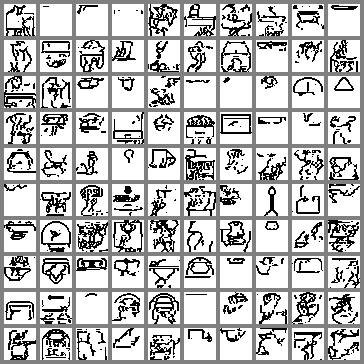

In [49]:
cols = 10
rows = 10
overview = PIL.Image.new('RGB', (cols * 36 + 4, rows * 36 + 4), (128, 128, 128))
for idx, icon in enumerate(generate_icons(model, num=cols * rows)):
    x = idx % cols
    y = idx // cols
    overview.paste(icon, (x * 36 + 4, y * 36 + 4))
overview

# 音频处理

## 音乐分类

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K

In [52]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        for song in os.listdir(genre_folder):
            if song.endswith('.au'):
                signal, sr = librosa.load(os.path.join(genre_folder, song))
                melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])
    return song_specs, genres, genre_to_idx, idx_to_genre

song_specs, genres, genre_to_idx, idx_to_genre = load_songs('/home/lq/datasets/genres')
song_specs[0].shape

(1280, 128)

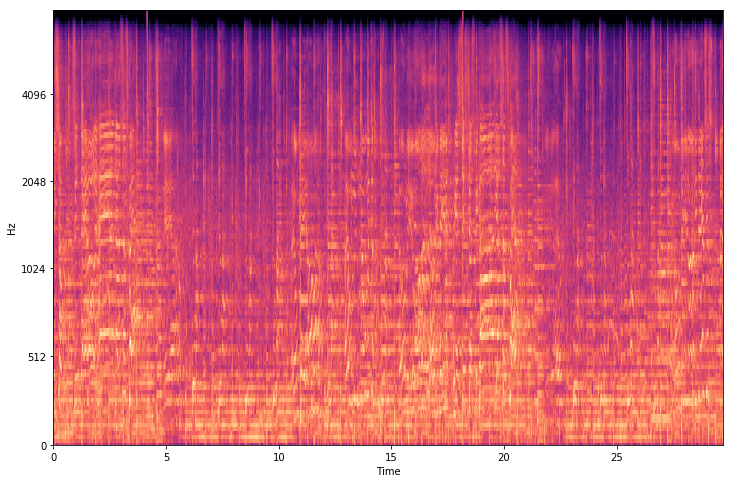

In [53]:
librosa.display.specshow(librosa.power_to_db(song_specs[101].T,
                                              ref=np.max),
                          y_axis='mel', fmax=8000,
                          x_axis='time')

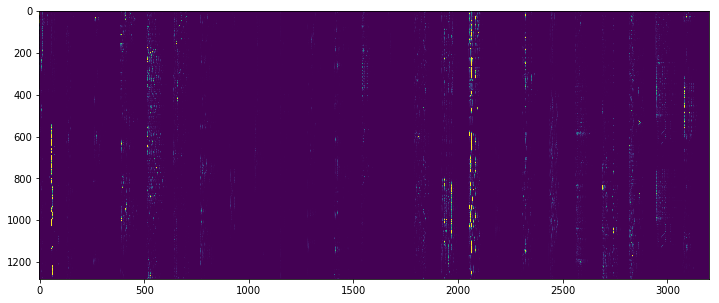

In [54]:
def show_spectogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(spec)
            if len(specs) == 25:
                break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.imshow((x *20).clip(0, 1.0))

show_spectogram('classical')

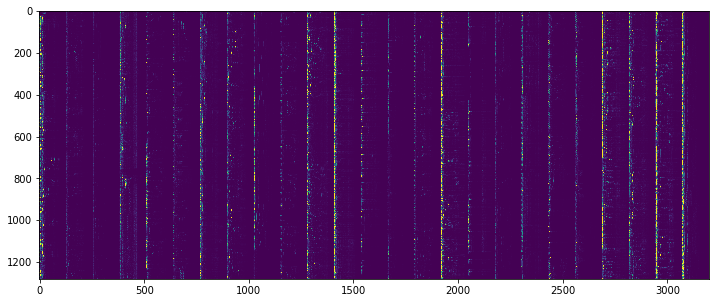

In [55]:
show_spectogram('metal')

In [56]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape, name='input')
    lstm_1 = LSTM(units=128, return_sequences=False)(inputs)
    
    dense2 = Dense(10, activation='softmax')(lstm_1)

    model = Model(inputs=[inputs], outputs=[dense2])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2
    
    # Global Layers
    x = GlobalMaxPooling1D()(x)

    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = cnn_model((128, 128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 128)           0         
__________

In [57]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)


genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

((9000, 128, 128), (9000, 10))

In [58]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=0,
      mode='auto')

    # Fit the model
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 5s 510us/step - loss: 3.6737 - acc: 0.1106 - val_loss: 2.2934 - val_acc: 0.1600
Epoch 2/100
9000/9000 [==============================] - 2s 205us/step - loss: 2.4598 - acc: 0.1733 - val_loss: 2.1402 - val_acc: 0.2660
Epoch 3/100
9000/9000 [==============================] - 2s 204us/step - loss: 2.2168 - acc: 0.2141 - val_loss: 2.0345 - val_acc: 0.3080
Epoch 4/100
9000/9000 [==============================] - 2s 206us/step - loss: 2.1157 - acc: 0.2486 - val_loss: 1.9556 - val_acc: 0.3360
Epoch 5/100
9000/9000 [==============================] - 2s 207us/step - loss: 2.0435 - acc: 0.2717 - val_loss: 1.9023 - val_acc: 0.3610
Epoch 6/100
9000/9000 [==============================] - 2s 213us/step - loss: 2.0022 - acc: 0.2842 - val_loss: 1.8552 - val_acc: 0.3700
Epoch 7/100
9000/9000 [==============================] - 2s 209us/step - loss: 1.9680 - acc: 0.3003 - val_loss: 1.8139 - val_acc: 

In [59]:
model.save('zoo/15/song_classify.h5')

In [60]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.62

In [61]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.62

In [63]:
cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[58 11 18  0  4  1  1  2  2  4]
 [ 2 17  0  0  7  2  3 12  1  2]
 [24 11 69  0  7  1  2  0  0  9]
 [ 0  2  0 97  0 11 10  0  6 10]
 [ 4 14  3  0 70  0  9 10  2 15]
 [ 0  2  0  3  0 65  0 19 13  4]
 [ 0 17  0  0  3  0 64 17  3  4]
 [ 1 11  0  0  5 10  3 25 21  1]
 [11 10  1  0  1  7  0  9 50 11]
 [ 0  5  9  0  3  3  8  6  2 40]]


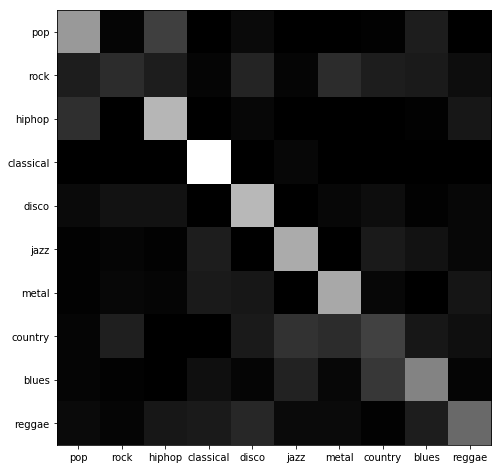

In [64]:
plt.imshow(cm.T, interpolation='nearest', cmap='gray')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre)
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

In [65]:
m1 = cnn_melspect_1D_org((128, 128))
m2 = cnn_melspect_1D((128, 128))
ac1 = 0.61 * 5
ac2 = 0
for i in range(5):
    history = m1.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac1 += history.history['val_acc'][-1]
    history = m2.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac2 += history.history['val_acc'][-1]

print(ac1 / 5, ac2 / 5)

NameError: name 'cnn_melspect_1D_org' is not defined

## MP3指数

In [ ]:
import os
from tinytag import TinyTag, TinyTagException
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from keras.models import load_model
import librosa
from collections import Counter
import multiprocessing
from tqdm import tqdm
from keras.models import Model
import numpy as np
import sounddevice as sd

In [ ]:
MUSIC_ROOT = '/Users/douwe/Songs/'
mp3s = []
for root, subdirs, files in os.walk(MUSIC_ROOT):
    for fn in files:
        if fn.endswith('.mp3'):
            mp3s.append(os.path.join(root, fn))
len(mp3s)

In [ ]:
TO_SKIP = {'Podcast', 'Books & Spoken'}

def process_mp3(path):
    try:
        tag = TinyTag.get(path)
        if tag.genre in TO_SKIP:
            return None
    except TinyTagException:
        print('error')
        return None
    signal, sr = librosa.load(path, res_type='kaiser_fast', offset=30, duration=30)
    try:
        melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
        if len(melspec) != 1280:
            return None
    except ValueError:
        return None
    return {'path': path,
            'melspecs': np.asarray(np.split(melspec, 10)),
            'tag': tag}

songs = [process_mp3(path) for path in tqdm(mp3s[:1000])]
songs = [song for song in songs if song]

In [ ]:
inputs = []
for song in songs:
    inputs.extend(song['melspecs'])
inputs = np.array(inputs)
inputs.shape

In [ ]:
cnn_model = load_model('zoo/15/song_classify.h5')
vectorize_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-4].output)
vectors = vectorize_model.predict(inputs)
vectors.shape

In [ ]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(vectors)

def most_similar_songs(song_idx):
    distances, indices = nbrs.kneighbors(vectors[song_idx * 10: song_idx * 10 + 10])
    c = Counter()
    for row in indices:
        for idx in row[1:]:
            c[idx // 10] += 1
    return c.most_common()

In [ ]:
song_idx = 7
print(songs[song_idx]['path'])

print('---')
for idx, score in most_similar_songs(song_idx)[:5]:
    print(songs[idx]['path'], score)
print('')

In [ ]:
duration = 30  # seconds
fs = 22050
myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
myrecording.shape

In [ ]:
sd.play(myrecording, samplerate=fs)
myrecording.min()

In [ ]:
signal, sr = librosa.load('/Users/douwe/Dropbox/Apps/Hi-Q Recordings/recording-20180219-162112.mp3', 
                          res_type='kaiser_fast', offset=0, duration=30)

melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
melspecs = np.asarray(np.split(melspec, 10))
melspecs.shape

In [ ]:
recorded_vectors = vectorize_model.predict(melspecs)
distances, indices = nbrs.kneighbors(recorded_vectors)
c = Counter()
for row in indices:
    for idx in row[1:]:
        c[idx // 10] += 1
for idx, _ in c.most_common():
    print(songs[idx]['path'])

In [ ]:
signal, sr = librosa.load('/Users/douwe/Dropbox/Apps/Hi-Q Recordings/recording-20180219-162112.mp3', 
                          res_type='kaiser_fast', offset=0, duration=30)
sd.play(signal.flatten(), samplerate=sr)

## 音乐推荐

In [ ]:
import gensim
import sqlite3
from operator import itemgetter

In [ ]:
class WordSplitter(object):
    def __init__(self, filename):
        self.filename = filename
 
    def __iter__(self):
        with open(self.filename) as fin:
            for line in fin:
                yield line.split()

model = gensim.models.Word2Vec(model_input, min_count=4)
model.save(open('zoo/15/songs.word2vec', 'wb'))

In [ ]:
conn = sqlite3.connect('data/songs.db')
def find_song(song_name, limit=10):
    c = conn.cursor()
    c.execute("SELECT * FROM songs WHERE UPPER(name) LIKE '%" + song_name + "%'")
    res = sorted((x + (model.wv.vocab[x[0]].count,) 
                  for x in c.fetchall() if x[0] in model.wv.vocab),
                 key=itemgetter(-1), reverse=True)
    return [*res][:limit]

for t in find_song('the eye of the tiger'):
    print(*t)

In [ ]:
def suggest_songs(song_id):
    c = conn.cursor()
    similar = dict(model.most_similar([song_id]))
    song_ids = ', '.join(("'%s'" % x) for x in similar.keys())
    c.execute("SELECT * FROM songs WHERE id in (%s)" % song_ids)
    res = sorted((rec + (similar[rec[0]],) for rec in c.fetchall()), 
                 key=itemgetter(-1),
                 reverse=True)
    return [*res]


for t in suggest_songs('4rr0ol3zvLiEBmep7HaHtx'):
    print(*t)

In [ ]:
x = model.wv.vocab['2yqVlvXgZ51ynGqwfYADx4']
x.count